# 03 — Exploratory Data Analysis & PCA

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pca_analysis import StockPCA

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Feature Matrix

In [2]:
feature_matrix = pd.read_parquet("../data/processed/feature_matrix.parquet")
fundamentals_df = pd.read_parquet("../data/raw/fundamentals.parquet")
print(f"Feature matrix: {feature_matrix.shape}")
feature_matrix.head()

Feature matrix: (30, 38)


,Open,High,Low,Close,Volume,SMA_20,Price_vs_SMA_20,SMA_50,Price_vs_SMA_50,SMA_200,Price_vs_SMA_200,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,BB_Bandwidth,BB_PctB,ATR,ATR_Pct,OBV,OBV_SMA,Return_1d,Return_5d,Return_21d,Volatility_5d,Volatility_21d,Volatility_63d,Momentum_5d,Momentum_10d,Momentum_21d,Momentum_63d,Volume_SMA_20,Volume_Ratio,Daily_Range,Gap
AAPL,271.679993,274.079987,271.049988,273.440002,8025261.0,267.433275,0.022461,265.479591,0.029985,241.847442,0.130630,47.401192,1.281394,0.779291,0.502103,281.979210,267.433275,252.887340,0.108782,0.706474,6.638536,0.024278,2.389771e+09,2.286205e+09,0.004777,0.034386,0.071594,0.219449,0.309511,0.223363,0.034386,-0.000877,0.071594,0.008125,5.297251e+07,0.151499,0.011081,-0.001690
MSFT,390.237488,400.089996,390.200012,399.880005,13342882.0,408.736789,-0.021669,447.585294,-0.106584,484.208878,-0.174158,42.526135,-16.602852,-17.465711,0.862860,450.854189,408.736789,366.619389,0.206086,0.394856,10.375890,0.025948,1.415958e+07,1.477505e+08,0.027969,0.002985,-0.147757,0.351368,0.462852,0.316265,0.002985,-0.030192,-0.147757,-0.151079,4.542097e+07,0.293760,0.024732,0.003181
GOOGL,311.994995,313.640015,309.630005,310.315002,7022300.0,320.363748,-0.031367,319.899300,-0.029960,247.853916,0.252008,28.367461,-4.495265,-3.352908,-1.142357,348.506474,320.363748,292.221023,0.175692,0.321468,9.747857,0.031413,1.694027e+09,1.874107e+09,-0.001882,0.023028,-0.068850,0.319971,0.232367,0.251048,0.023028,-0.025943,-0.068850,0.036234,4.016148e+07,0.174852,0.012922,0.003522
AMZN,210.460007,211.589996,209.589493,210.554993,9106977.0,216.753250,-0.028596,227.205500,-0.073284,224.264775,-0.061132,29.840946,-7.265889,-7.496922,0.231032,249.437910,216.753250,184.068590,0.301584,0.405181,7.572144,0.035963,6.264639e+08,7.700281e+08,0.009566,0.028151,-0.116874,0.294122,0.339770,0.276230,0.028151,0.017370,-0.116874,-0.045924,6.302371e+07,0.144501,0.009501,0.009110
NVDA,194.470001,196.559998,193.800003,195.659897,61701133.0,187.084995,0.045834,185.407599,0.055296,174.334075,0.122327,74.548298,1.884083,0.866593,1.017490,199.150318,187.084995,175.019672,0.128982,0.855353,6.263572,0.032013,6.405971e+09,5.995945e+09,0.014570,0.040855,0.049284,0.087591,0.386331,0.321975,0.040855,0.037763,0.049284,0.093866,1.691671e+08,0.364735,0.014106,0.008400


## 2. Feature Distributions

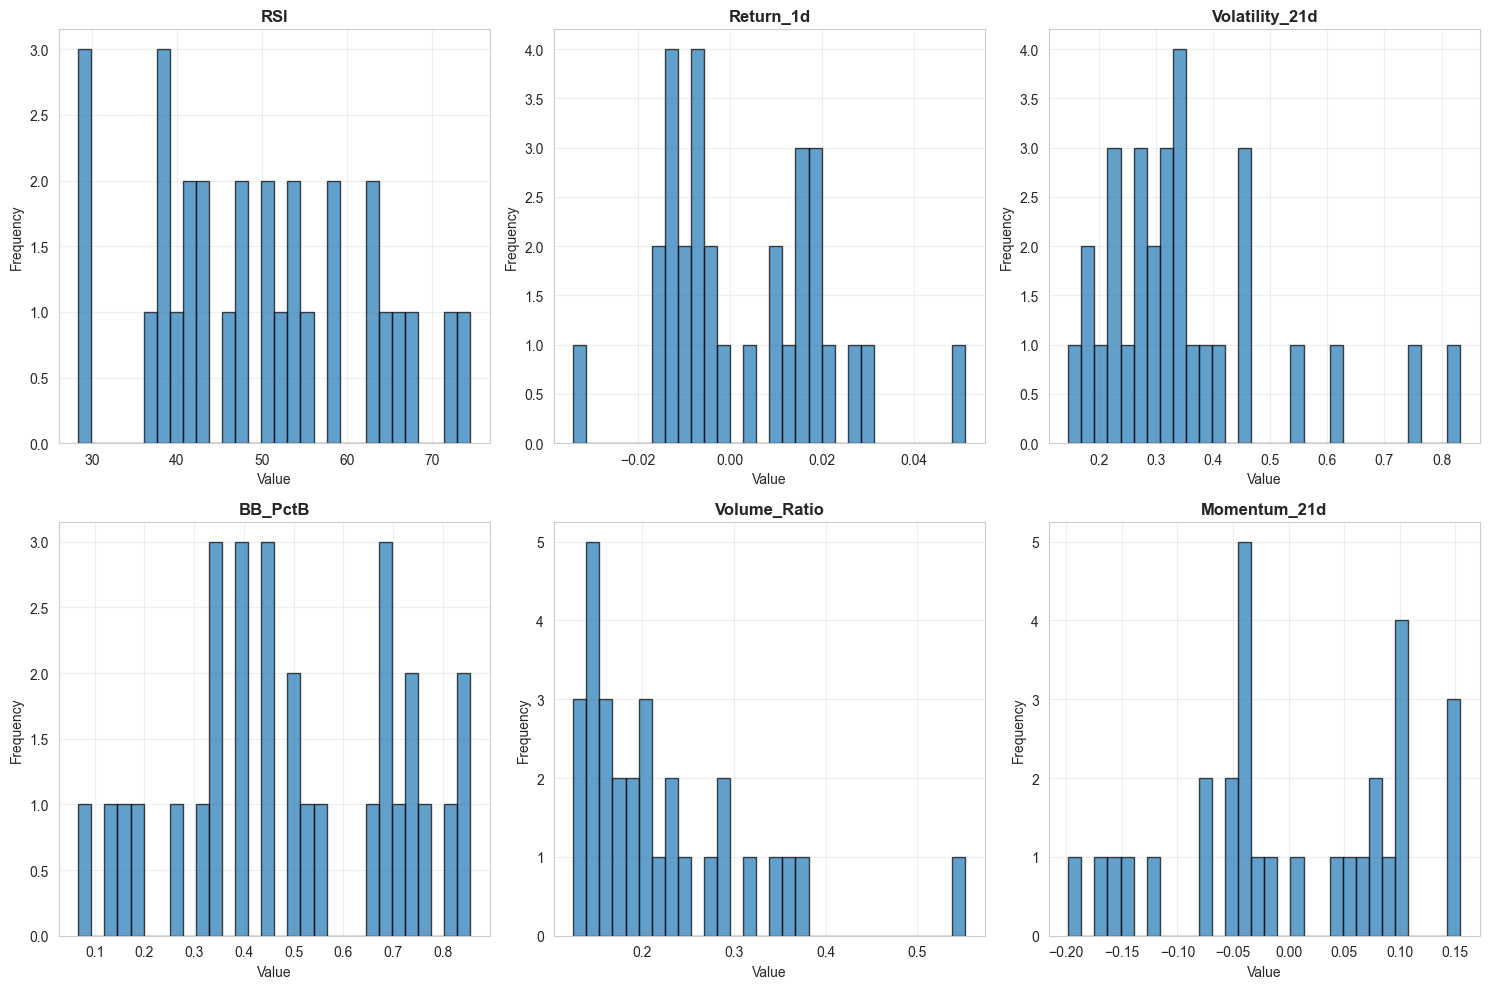

In [3]:
# Select 6 key features
key_features = ['RSI', 'Return_1d', 'Volatility_21d', 'BB_PctB', 'Volume_Ratio', 'Momentum_21d']
available_features = [f for f in key_features if f in feature_matrix.columns]

if len(available_features) >= 6:
    features_to_plot = available_features[:6]
else:
    features_to_plot = feature_matrix.columns[:6].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(feature_matrix[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(feature, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/03_feature_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Correlation Analysis

Top 10 Correlated Pairs:
  SMA_20 <-> BB_Middle: 1.000
  Return_5d <-> Momentum_5d: 1.000
  Return_21d <-> Momentum_21d: 1.000
  High <-> Low: 1.000
  Open <-> Low: 1.000
  Low <-> Close: 1.000
  Open <-> High: 1.000
  High <-> Close: 1.000
  Open <-> Close: 1.000
  Close <-> SMA_20: 0.999


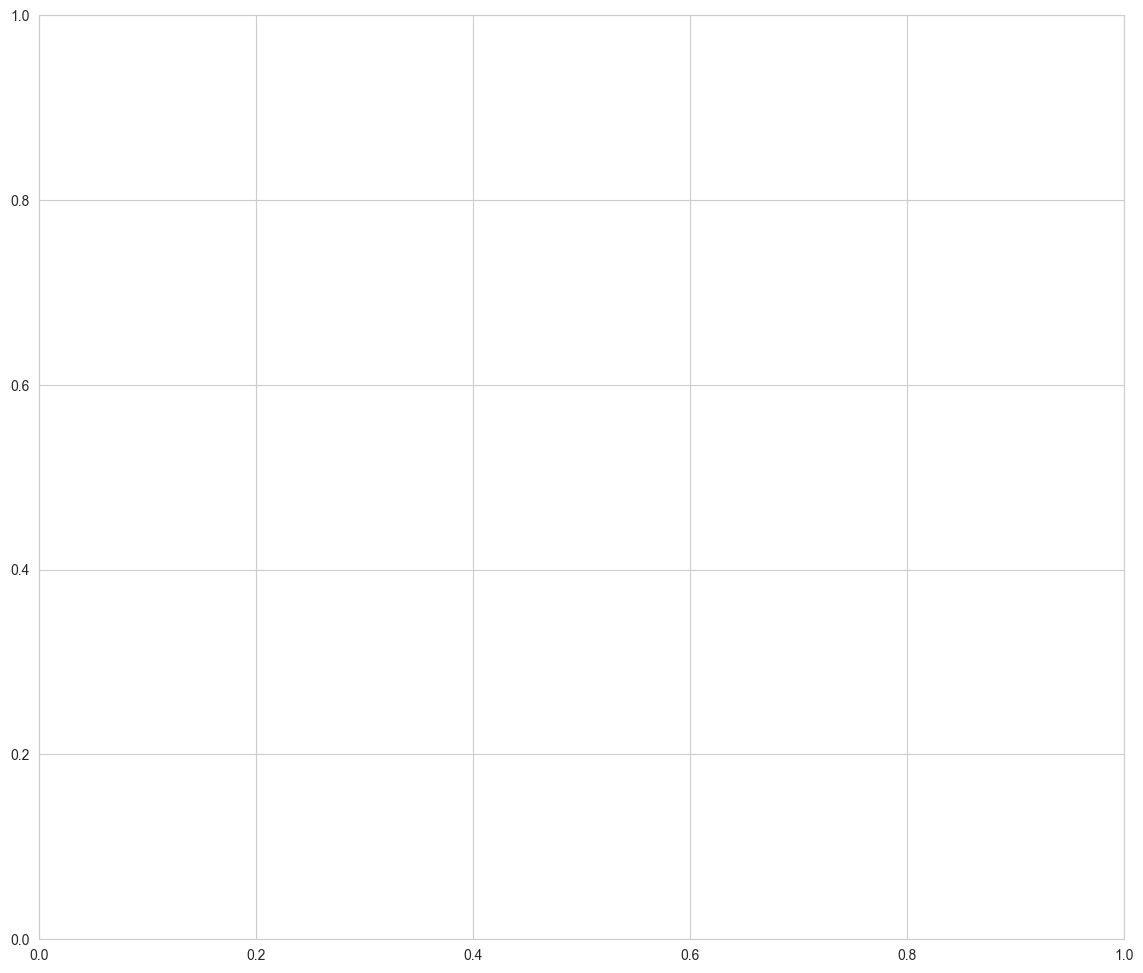

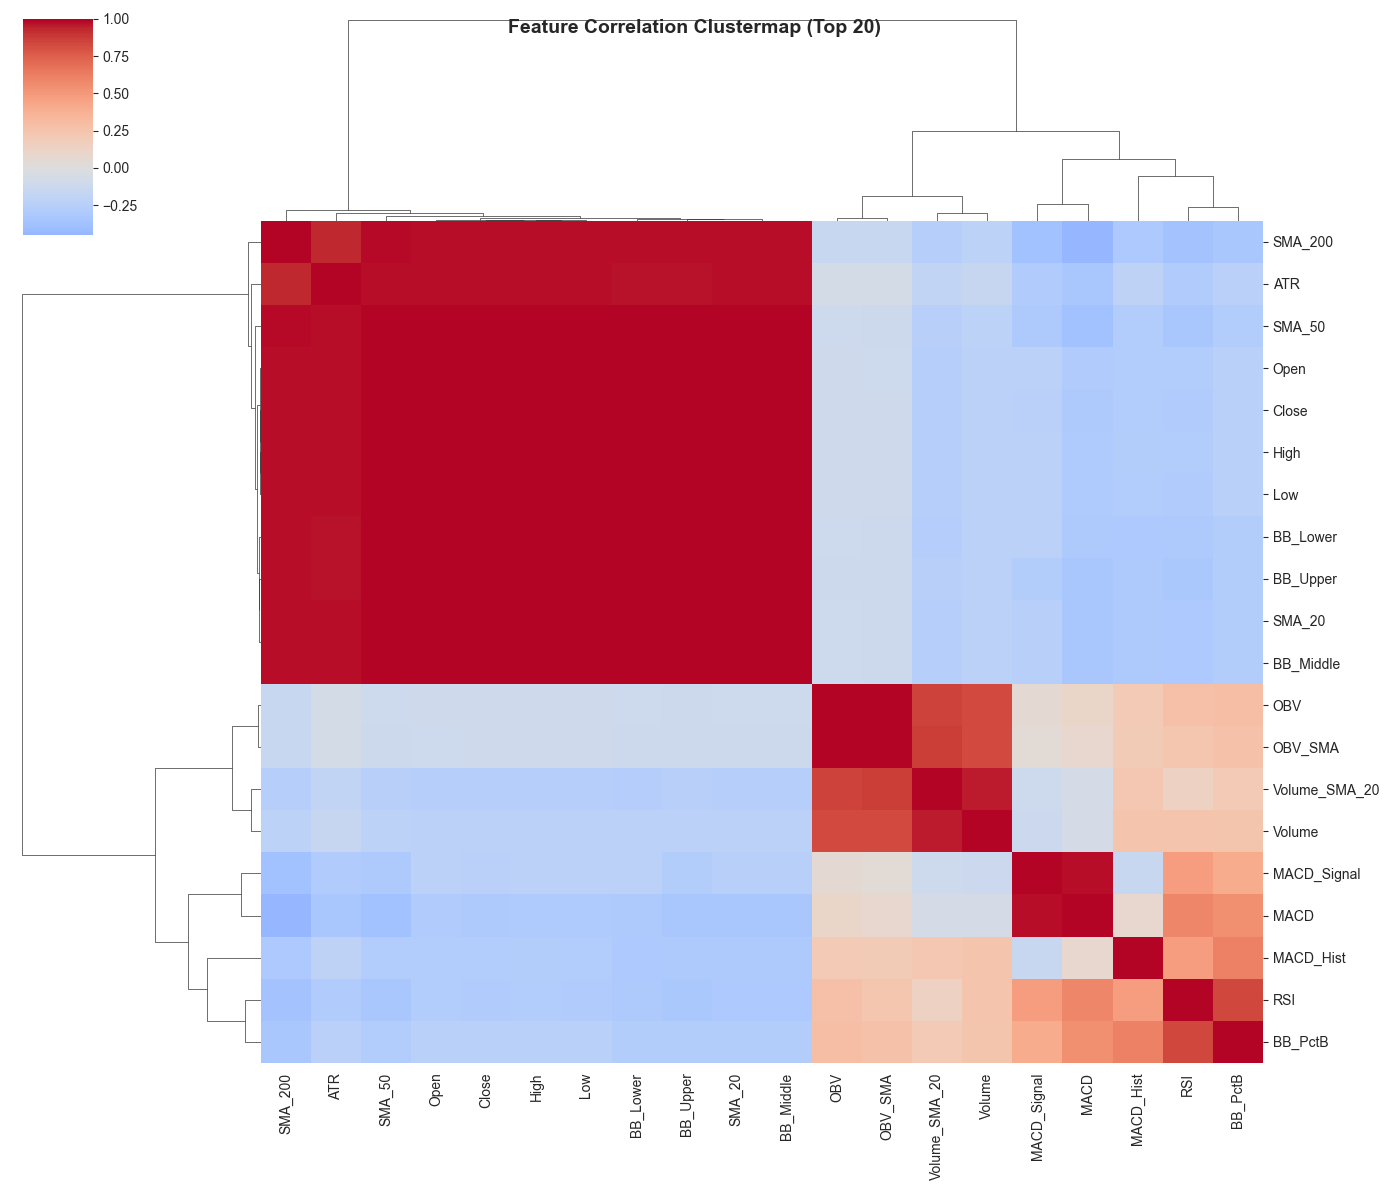

In [4]:
# Compute correlation matrix
numeric_features = feature_matrix.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()

# Find top 10 correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
print(f"Top 10 Correlated Pairs:")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))
top_features = numeric_features.var().nlargest(20).index
sns.clustermap(corr_matrix.loc[top_features, top_features], cmap='coolwarm', center=0, figsize=(14, 12))
plt.suptitle('Feature Correlation Clustermap (Top 20)', fontsize=14, fontweight='bold', y=0.98)
plt.savefig("../figures/03_correlation_clustermap.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Apply PCA

In [5]:
stock_pca = StockPCA(variance_threshold=0.90)
pca_data_df = stock_pca.fit_transform(numeric_features)
print(f"\nPCA output shape: {pca_data_df.shape}")
pca_data_df.head()

Auto-selected 7 components (explaining 91.9% variance)

PCA output shape: (30, 7)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
AAPL,-1.795349,-1.038349,1.790160,0.533159,-1.135487,1.441143,-0.567652
MSFT,3.904904,3.464592,-0.116550,-0.979779,-1.814639,0.897122,-0.607609
GOOGL,0.926749,0.518304,-0.213207,1.831289,0.030127,2.237144,-0.037069
AMZN,0.427949,2.934493,-0.155520,0.316212,-0.653654,3.472595,1.219996
NVDA,-4.259306,1.619077,7.220096,4.237513,-2.550221,-0.523721,-1.160518


## 5. Explained Variance Analysis

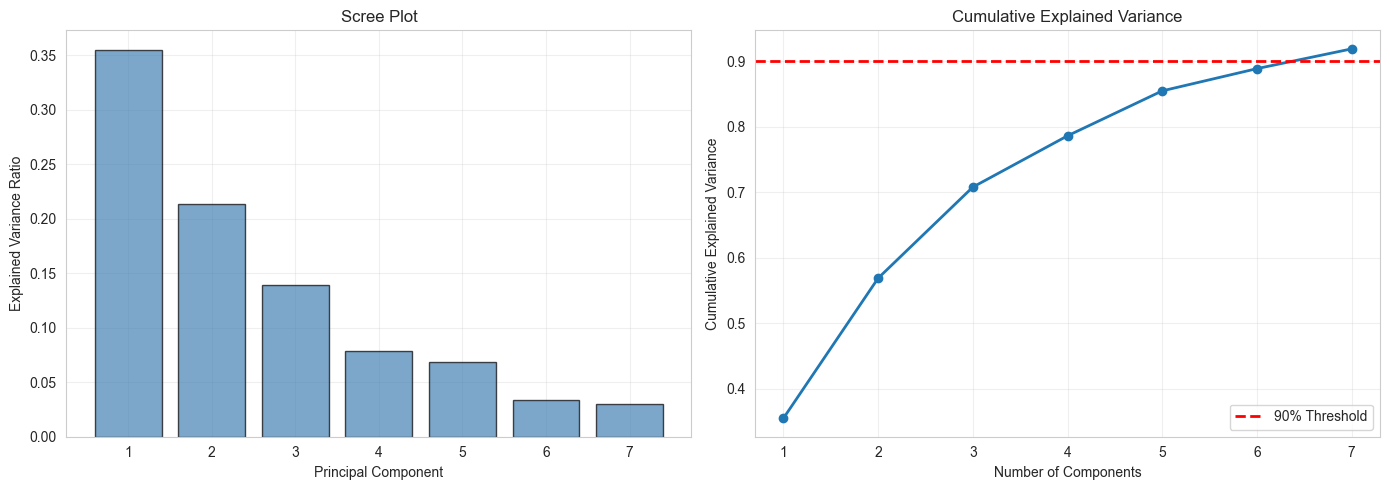

  Component  Variance  Cumulative
0       PC1  0.355242    0.355242
1       PC2  0.213808    0.569050
2       PC3  0.139042    0.708092
3       PC4  0.078280    0.786372
4       PC5  0.068600    0.854972
5       PC6  0.033947    0.888919
6       PC7  0.030167    0.919087


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
var_ratios = stock_pca.pca.explained_variance_ratio_
n_comp = min(20, len(var_ratios))
axes[0].bar(range(1, n_comp+1), var_ratios[:n_comp], alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].grid(alpha=0.3)

# Cumulative variance
cumsum_var = np.cumsum(var_ratios)
axes[1].plot(range(1, len(cumsum_var)+1), cumsum_var, marker='o', linewidth=2, markersize=6)
axes[1].axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90% Threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/03_scree_plot.png", dpi=150, bbox_inches="tight")
plt.show()

# Print variance
var_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(var_ratios))],
    'Variance': var_ratios,
    'Cumulative': cumsum_var
})
print(var_df.to_string())

## 6. PCA Loadings Analysis


PC1 Top Features:
  Positive: ['SMA_200', 'SMA_50', 'BB_Upper', 'SMA_20', 'BB_Middle']
  Negative: ['MACD', 'Price_vs_SMA_50', 'Return_21d', 'Momentum_21d', 'Price_vs_SMA_20']

PC2 Top Features:
  Positive: ['Volume_Ratio', 'ATR_Pct', 'Volatility_21d', 'Volatility_5d', 'BB_Bandwidth']
  Negative: ['MACD_Signal', 'Price_vs_SMA_50', 'Return_21d', 'Momentum_21d', 'MACD']

PC3 Top Features:
  Positive: ['Return_5d', 'Momentum_5d', 'OBV', 'OBV_SMA', 'Volume']
  Negative: ['Momentum_63d', 'MACD_Signal', 'Daily_Range', 'Volatility_5d', 'MACD']


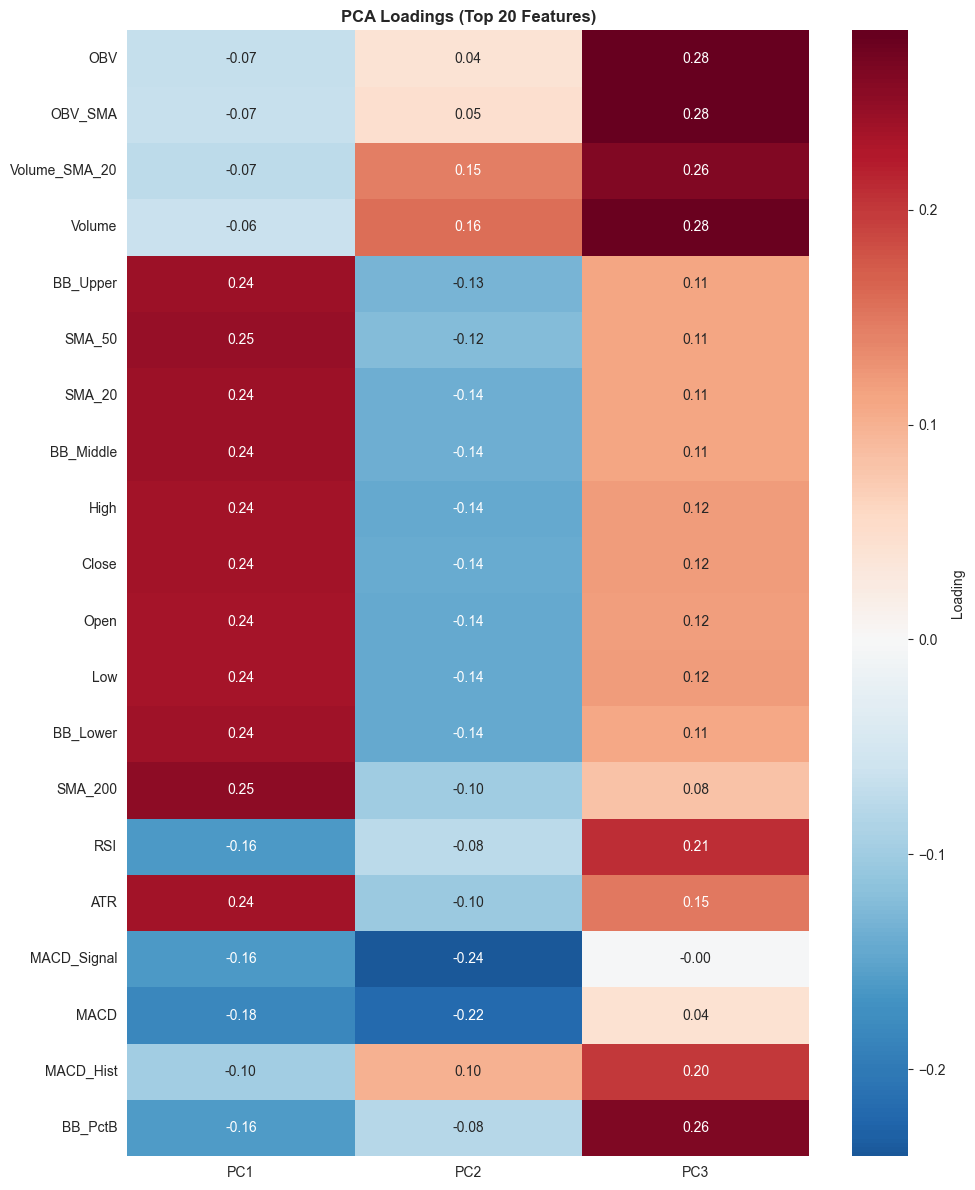

In [7]:
loadings = pd.DataFrame(
    stock_pca.pca.components_.T,
    columns=[f'PC{i+1}' for i in range(stock_pca.pca.components_.shape[0])],
    index=numeric_features.columns
)

# Top features for first 3 PCs
n_pcs_to_show = min(3, len(loadings.columns))
for pc_num in range(1, n_pcs_to_show + 1):
    pc_name = f'PC{pc_num}'
    top_pos = loadings[pc_name].nlargest(5)
    top_neg = loadings[pc_name].nsmallest(5)
    print(f"\n{pc_name} Top Features:")
    print(f"  Positive: {list(top_pos.index)}")
    print(f"  Negative: {list(top_neg.index)}")

# Plot loadings heatmap
top_20_var = numeric_features.var().nlargest(20).index
pc_cols = [f'PC{i+1}' for i in range(min(3, len(loadings.columns)))]
top_loadings = loadings.loc[top_20_var, pc_cols]
plt.figure(figsize=(10, 12))
sns.heatmap(top_loadings, cmap='RdBu_r', center=0, annot=True, fmt='.2f', cbar_kws={'label': 'Loading'})
plt.title('PCA Loadings (Top 20 Features)', fontweight='bold')
plt.tight_layout()
plt.savefig("../figures/03_pca_loadings.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Stocks in PCA Space

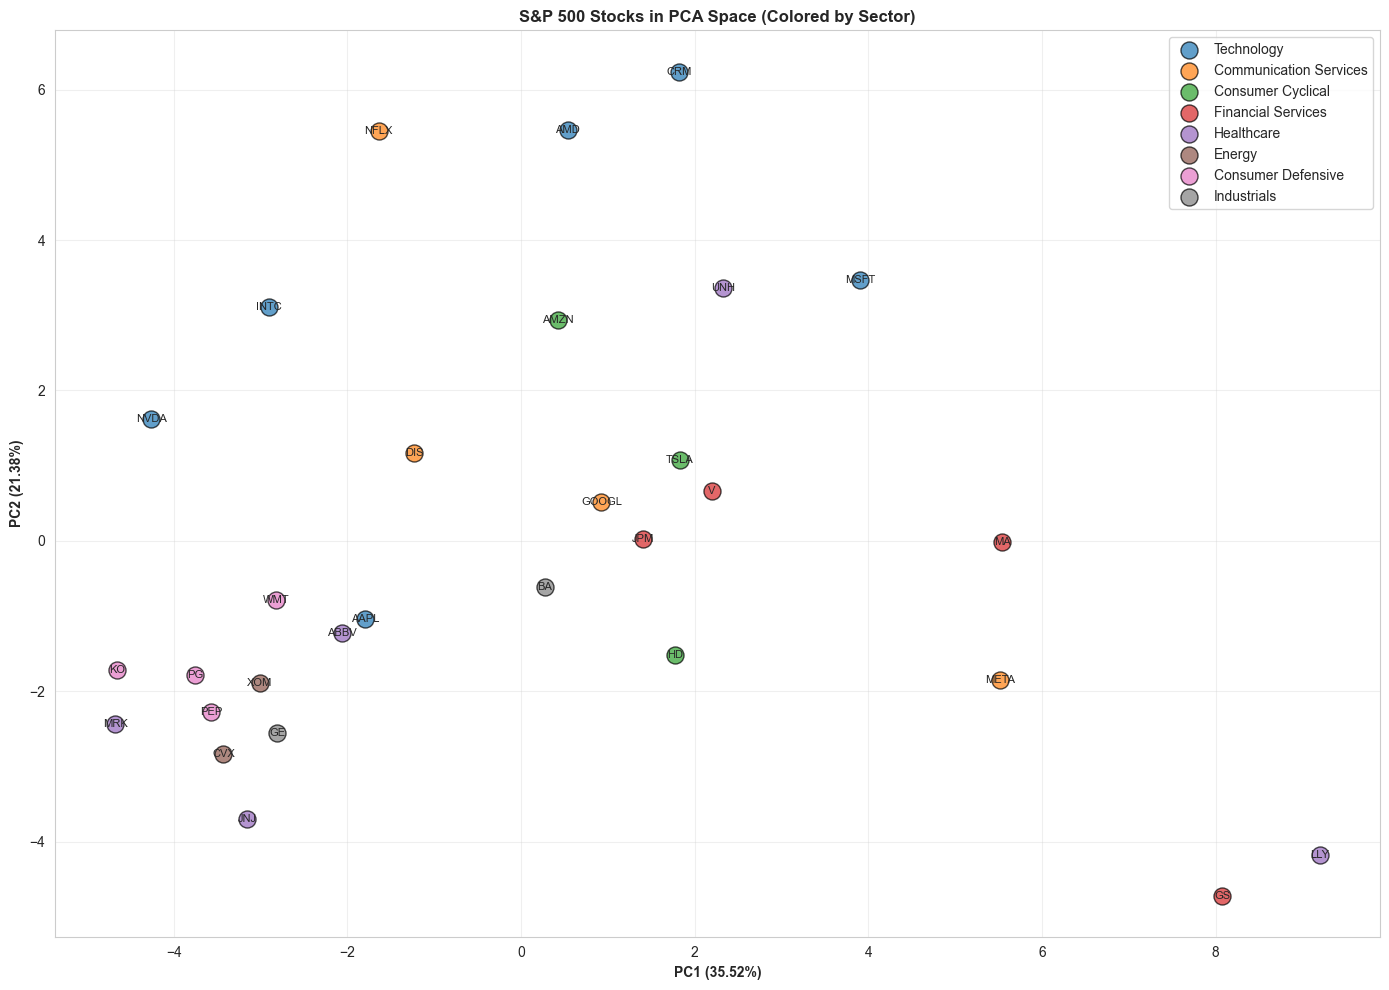

In [8]:
# Get sector from fundamentals if available
if 'sector' in fundamentals_df.columns:
    sectors = fundamentals_df.loc[fundamentals_df.index.isin(pca_data_df.index)].reindex(pca_data_df.index)['sector'].fillna('Unknown')
else:
    sectors = pd.Series('Unknown', index=pca_data_df.index)

# Plot stocks in PCA space
fig, ax = plt.subplots(figsize=(14, 10))
for sector in sectors.unique():
    mask = sectors == sector
    ax.scatter(pca_data_df[mask].iloc[:, 0], pca_data_df[mask].iloc[:, 1], s=150, alpha=0.7, label=sector, edgecolors='black', linewidth=1)

# Add ticker labels
for i, ticker in enumerate(pca_data_df.index):
    ax.annotate(ticker, (pca_data_df.iloc[i, 0], pca_data_df.iloc[i, 1]), fontsize=8, ha='center', va='center')

var_ratios = stock_pca.pca.explained_variance_ratio_
ax.set_xlabel(f'PC1 ({var_ratios[0]:.2%})', fontweight='bold')
ax.set_ylabel(f'PC2 ({var_ratios[1]:.2%})', fontweight='bold')
ax.set_title('S&P 500 Stocks in PCA Space (Colored by Sector)', fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../figures/03_pca_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Save PCA Results

In [9]:
os.makedirs("../data/processed", exist_ok=True)
pca_data_df.to_parquet("../data/processed/pca_data.parquet")
feature_matrix.to_parquet("../data/processed/feature_matrix.parquet")
print(f"Saved PCA data: {pca_data_df.shape}")
print(f"Saved feature_matrix: {feature_matrix.shape}")

Saved PCA data: (30, 7)
Saved feature_matrix: (30, 38)
